# Replicating Results with parameter values from Geoffroy 2

- $C$ = 8.2 ± 0.9 ($W yr m^{-2}K^{-1}$)
- $C_0$ = 109 ± 52 ($W yr m^{-2}K^{-1}$)
- $\gamma_0$ = 0.67 ± 0.15 ($W m^{-2}K^{-1}$)
- $\varepsilon$ = 1.28 ± 0.25 
- $\lambda$ = 1.18 ± 0.37 ($Wm^{-2}K^{-1}$)
- $\mathcal{F}_{4\text{xCO}_2}$ = 7.6 ± 1 ($Wm^{-2}$)


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

In [6]:
runs = {}

In [25]:
kappas = [0.15]

for run in [1]:
    for k in kappas:    
        print(f"currently on %s * 4xCO2, kappa %s "%(run, k))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= run * 7.6 * np.ones(751),
                exttime=np.arange(1750,2501),
                tbeg=1750,
                tend=2501,
                lamg=1.18,
                t2x=None,
                eff=1.28,
                cmix=8.2,
                cdeep=109,
                gamma_2l=0.67,
                kappa=k, 
                sigma = 0.01,
                outtime=np.arange(1750.5,2501),
                dt=3
            )
        
            out = scm.run()
    
        runs[f"Constant %s * 4xCO2 forcing, kappa: %s"%(run, k)] = out
    

currently on 1 * 4xCO2, kappa 0.2 


100%|██████████| 1000/1000 [00:21<00:00, 46.93it/s]


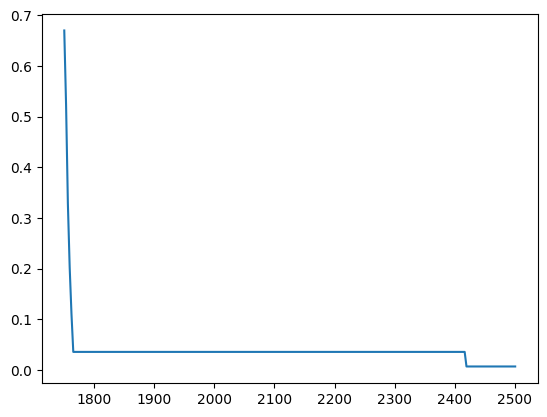

In [26]:
plt.plot(out.time[::3], out.gammas)

In [79]:
kappas = [0,0.15]

for run in [+1, -1]:
    for k in kappas:    
        print(f"currently on %s * 4xCO2, kappa %s "%(run, k))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= run * 7.6 * np.ones(751),
                exttime=np.arange(1750,2501),
                tbeg=1750,
                tend=2501,
                lamg=1.18,
                t2x=None,
                eff=1.28,
                cmix=8.2,
                cdeep=109,
                gamma_2l=0.67,
                kappa=k, 
                sigma = 0.01,
                outtime=np.arange(1750.5,2501),
                dt=1
            )
        
            out = scm.run()
    
        runs[f"Constant %s * 4xCO2 forcing, kappa: %s"%(run, k)] = out

currently on 1 * 4xCO2, kappa 0 


100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]


currently on 1 * 4xCO2, kappa 0.15 


100%|██████████| 1000/1000 [01:03<00:00, 15.71it/s]


currently on -1 * 4xCO2, kappa 0 


100%|██████████| 1000/1000 [1:12:24<00:00,  4.34s/it]   


currently on -1 * 4xCO2, kappa 0.15 


100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


['Constant 1 * 4xCO2 forcing, kappa: 0', 'Constant 1 * 4xCO2 forcing, kappa: 0.15', 'Constant -1 * 4xCO2 forcing, kappa: 0', 'Constant -1 * 4xCO2 forcing, kappa: 0.15']
[Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev']]
0
0
5
5
0
0
5
5


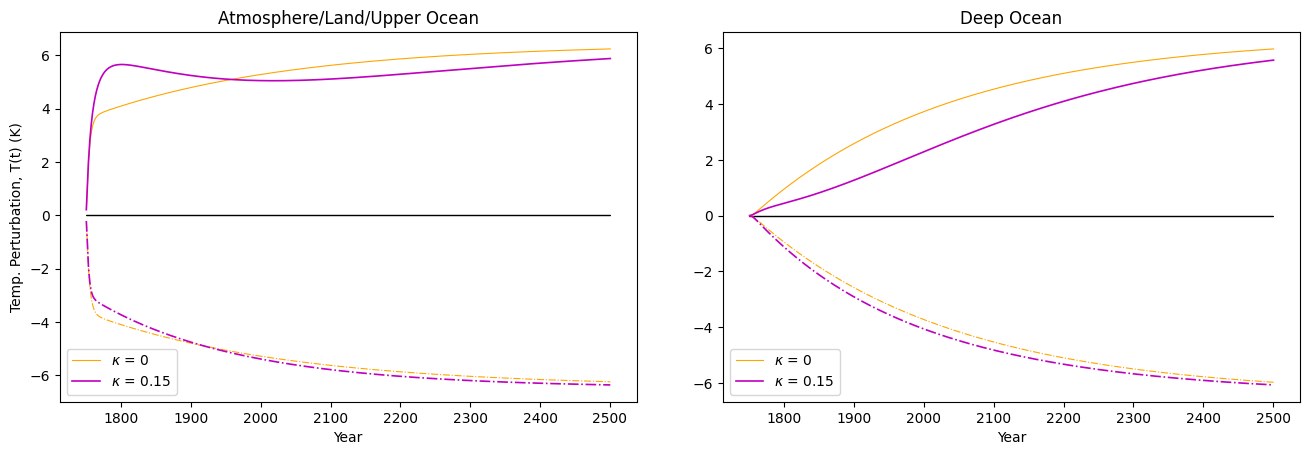

In [32]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t) (K)')

#fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)
kappas = [0, 0.15]
scenario_names = []
for run in [+1, -1]:
    for k in kappas:
        scenario_names.append(f"Constant %s * 4xCO2 forcing, kappa: %s"%(run, k))
print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
print(run_outputs)

layers = ["Atmosphere/Land/Upper Ocean", "Deep Ocean"]
colors = ["orange", "m", "orange", "m", "c"]

for (run, scen, color) in zip (run_outputs, scenario_names, colors):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        style = "dashdot"
        if scen.index("1")== 9:
            style = None
        w =0.8
        k = f"$\kappa$ = 0"
        print(scen[-1])
        if scen[-1] == "5":
            w = 1.2
            k = f"$\kappa$ = 0.15"
        if col == 0:
            subpl.plot(run.time, run.tg, label = k, color = color, linestyle = style, linewidth = w)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = k, color = color,linestyle = style, linewidth = w)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        #subpl.set_ylim(-4,4)
        subpl.hlines(0, 1750, 2500, linewidth = 0.8)
    
    
for subpl in axs:
    
    subpl.legend([f"$\kappa$ = 0",f"$\kappa$ = 0.15"], loc = "lower left")

In [36]:
espilons = [1,10]

for run in [+1, -1]:
    for e in espilons:    
        print(f"currently on %s * 4xCO2, epsilon %s "%(run, e))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= run * 7.6 * np.ones(751),
                exttime=np.arange(1750,2501),
                tbeg=1750,
                tend=2501,
                lamg=1.18,
                t2x=None,
                eff=e,
                cmix=8.2,
                cdeep=109,
                gamma_2l=0.67,
                kappa=0, 
                sigma = 0.01,
                outtime=np.arange(1750.5,2501),
                dt=1
            )
        
            out = scm.run()
    
        runs[f"Constant %s * 4xCO2 forcing, epsilon: %s"%(run, e)] = out

currently on 1 * 4xCO2, epsilon 1 


100%|██████████| 1000/1000 [01:20<00:00, 12.41it/s]


currently on 1 * 4xCO2, epsilon 10 


100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


currently on -1 * 4xCO2, epsilon 1 


100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


currently on -1 * 4xCO2, epsilon 10 


100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


['Constant 1 * 4xCO2 forcing, epsilon: 1', 'Constant 1 * 4xCO2 forcing, epsilon: 10', 'Constant -1 * 4xCO2 forcing, epsilon: 1', 'Constant -1 * 4xCO2 forcing, epsilon: 10']
[Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev']]
 
 
1
1
 
 
1
1


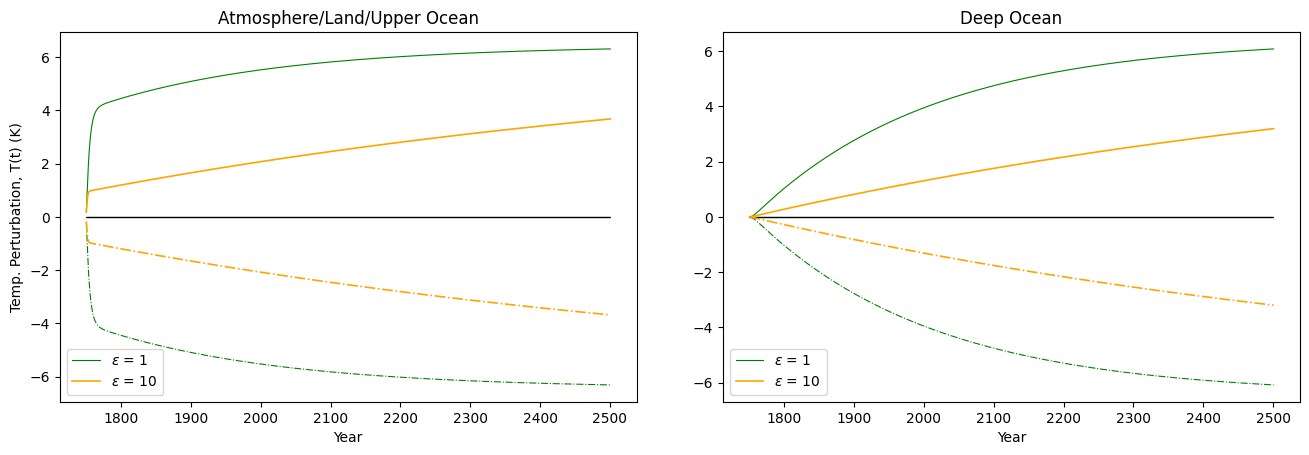

In [41]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t) (K)')

#fig.suptitle("Const. 4xCO2 forcing with various epsilon")
#print(runs)
epsilons = [1, 10]
scenario_names = []
for run in [+1, -1]:
    for e in epsilons:
        scenario_names.append(f"Constant %s * 4xCO2 forcing, epsilon: %s"%(run, e))
print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
print(run_outputs)

layers = ["Atmosphere/Land/Upper Ocean", "Deep Ocean"]
colors = ["green", "orange", "green",  "orange", "green", "c"]

for (run, scen, color) in zip (run_outputs, scenario_names, colors):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        style = "dashdot"
        if scen.index("1")== 9:
            style = None
        w =0.8
        e = f"$\epsilon$ = 0"
        print(scen[-2])
        if scen[-2] == "1":
            w = 1.2
            e = f"$\epsilon$ = 10"
        if col == 0:
            subpl.plot(run.time, run.tg, label = e, color = color, linestyle = style, linewidth = w)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = e, color = color,linestyle = style, linewidth = w)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        #subpl.set_ylim(-4,4)
        subpl.hlines(0, 1750, 2500, linewidth = 0.8)
    
    
for subpl in axs:
    
    subpl.legend([f"$\epsilon$ = 1",f"$\epsilon$ = 10"], loc = "lower left")
    

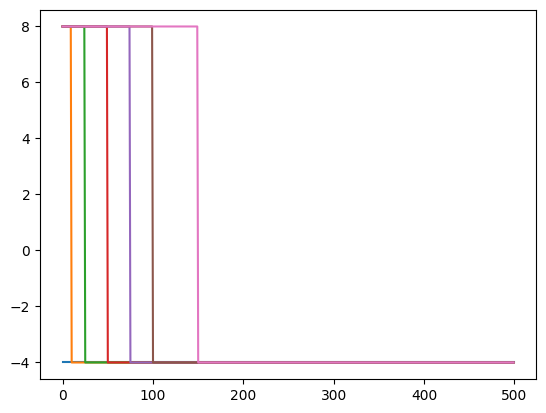

In [56]:
ts = np.array([0,10 ,25,50,75,100,150])

f_scenarios = {}

for t in ts:
    force = (np.ones(500) * -4)
    force[:t] *= -2
    f_scenarios[t] = force

for f in f_scenarios:
    plt.plot(f_scenarios[f])


run_names = []

k = 0.1

for t in ts:
    run_names.append(f"t = %s, k = %s" %(t,0))
    run_names.append(f"t = %s, k = %s" %(t,k))




In [57]:
runs = {}
kappas = [0, 0.1]
#ts = [0, 150]

for k in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(k,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=1.18,
                t2x=None,
                eff=1.28,
                cmix=8.2,
                cdeep=109,
                gamma_2l=0.67,
                kappa=k, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=1   
            )
        
            out = scm.run()
    
        runs[f"t = %s, k = %s" %(t,k)] = out
    

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:44<00:00, 22.25it/s]


currently on kappa 0, t:10 


100%|██████████| 1000/1000 [00:43<00:00, 22.86it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:34<00:00, 28.84it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:34<00:00, 29.20it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:33<00:00, 29.42it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:34<00:00, 29.27it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:34<00:00, 29.25it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


currently on kappa 0.1, t:10 


100%|██████████| 1000/1000 [00:39<00:00, 25.32it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:40<00:00, 24.74it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:39<00:00, 25.22it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [00:39<00:00, 25.17it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


10
25
50
75
100
10
25
50
75
100
0
150
0
150
0.7078491965389376 91.17923362175527
0.7078697981046566 93.45529460238983
[  80  200  400  600  800    0 1200]


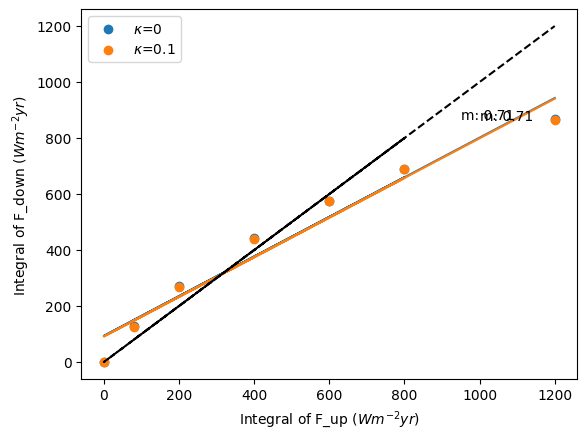

In [99]:
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time

import matplotlib.pyplot as plt


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs_new:
    run = runs_new[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        fint_up.append( 8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)



#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
print(xs)

fig, axs = plt.subplots()

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(fint_up, fint_up, "k", linestyle= "dashed")
axs.set_xlabel("Integral of F_up ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of F_down ($Wm^{-2} yr$) ")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1]-250,fint_down0[-1] ))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1]-200,fint_down01[-1] ))
axs.legend()
plt.show()



Why do we get the same coefficient as Bouttes? That was from AOGCM data and we get it when we have kappa = 0, ie.with out supposedly symmetric system?? What is happening?


0
10
25
50
75
100
150
0
10
25
50
75
100
150
0.4212608158220027 40.894932014833145
0.5758755665430575 54.732591676967516


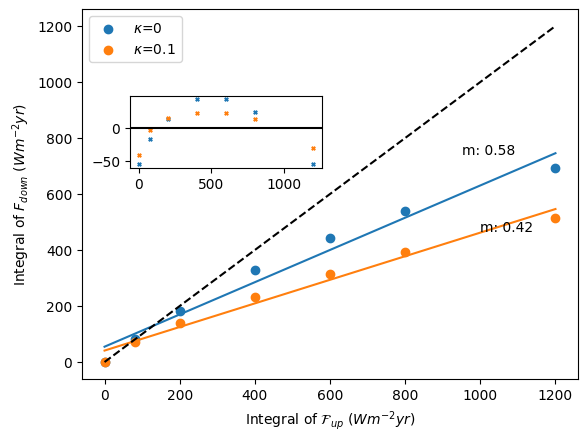

In [153]:
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time


import matplotlib.pyplot as plt
#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs:
    run = runs[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        fint_up.append( 8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)

residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(fint_up, fint_up, "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1]-250,fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1]-200,fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")


1196.0


Text(400.0, 1.2, '')

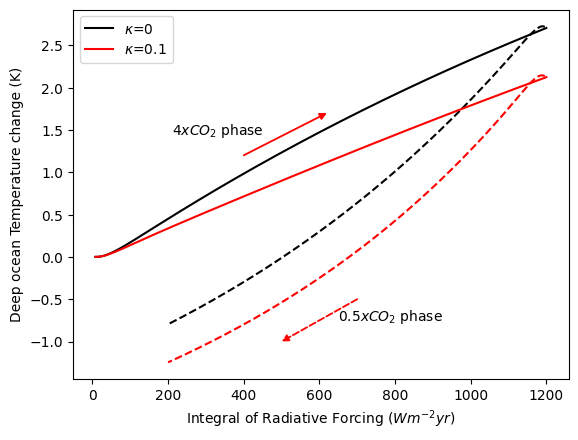

In [226]:
for name in runs:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 150:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    plt.legend()

arrowStart=np.array([500,-1])
arrowStop=np.array([700,-0.5])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+50,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.7])
arrowStop2=np.array([400,1.2])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))

In [88]:
print(runs)

{}


In [ ]:
for run, t in zip(runs,ts):
    plt.plot(fint_up, run.tlev[:,1][:t])
    plt.plot(fint_down0, run.tlev[:,1][t:], linestyle = "dashed")

# Rerunning with Bouttes Parameter values

In [80]:
d_l = 100       # m
d_k = 2000      # m

alpha = 0.81    # W m^-2 K^-2
c = 4.218e6     # J m^-3 K^-1
k = 1e-4        # m^2 s^-1  

gamma = c * k / (0.5 * (d_l + d_k))
print(gamma)

C_0 = c * d_l / (60*60*24*365)
C = c * d_k / (60*60*24*365)

print(C, C_0)


0.40171428571428575
267.50380517503805 13.375190258751903


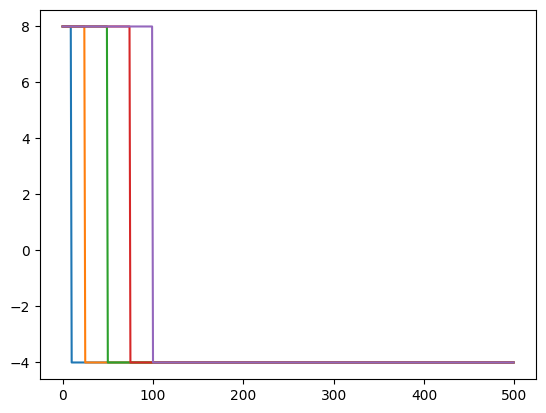

In [5]:
ts = np.array([10 ,25,50,75,100])

f_scenarios = {}

for t in ts:
    force = (np.ones(500) * -4)
    force[:t] *= -2
    f_scenarios[t] = force

for f in f_scenarios:
    plt.plot(f_scenarios[f])


run_names = []


for t in ts:
    run_names.append(f"t = %s, k = %s" %(t,0))
    run_names.append(f"t = %s, k = %s" %(t,0.1))


In [81]:
#runs_new = {}
kappas = [0, 0.1]
ts = [0,150]

for kappa in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(kappa,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=alpha,
                t2x=None,
                eff=1, #No epsilon
                cmix=C,
                cdeep=C_0,
                gamma_2l=c * k / (0.5 * (d_l + d_k)),
                kappa=kappa, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=1   
            )
        
            out = scm.run()
    
        runs_new[f"t = %s, k = %s" %(t,kappa)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:46<00:00, 21.49it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:40<00:00, 24.45it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:45<00:00, 21.84it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:42<00:00, 23.50it/s]


In [2]:
print(runs_new)

NameError: name 'runs_new' is not defined

t = 10, k = 0
10
0.0022794060640561886
t = 25, k = 0
25
0.0005947598349098082
t = 50, k = 0
50
0.0022711809016990325
t = 75, k = 0
75
0.006845445627843949
t = 100, k = 0
100
0.002685035751693099
t = 10, k = 0.1
10
0.002950941906756238
t = 25, k = 0.1
25
0.005460588018273593
t = 50, k = 0.1
50
0.00570743580134131
t = 75, k = 0.1
75
0.0021455141302110237
t = 100, k = 0.1
100
0.003914936101147071


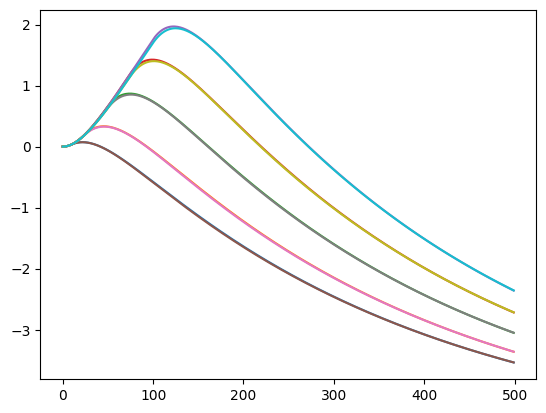

In [7]:
for name in runs_new:
    run = runs_new[name] 
    print(name)   
    plt.plot(run.time, run.tlev[:,1] ,label =name  )
    #plt.plot(run.time, run.tg)
    #plt.plot(run.time, run.gammas,label =name )
    t = int(name[name.find("= ")+2:name.find(", ")])
    print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    #print(run.tlev[:,1])
    #print(abs(run.tlev[:,1])[25:])
    print(minv)
    i = np.where(abs(run.tlev[:,1]) == minv)
    #print(run.time[i])
plt.scatter(t_0k, np.zeros(len(t_0k)))
plt.scatter(t_01k, np.zeros(len(t_0k)))

In [66]:
print(runs_new)

{'t = 10, k = 0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 25, k = 0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 50, k = 0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 75, k = 0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 100, k = 0': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 10, k = 0.1': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 25, k = 0.1': Results, public attributes: ['gammas', 'hflux', 'keys', 'lam_eff', 'ohc', 'params', 'qtot', 'tg', 'time', 'tlev'], 't = 50, k = 0.1': Results, public attributes: ['gammas', 'hflux', 'ke

10
25
50
75
100
0
150
0.7078491965389376 91.17923362175527
0.7078697981046566 93.45529460238983


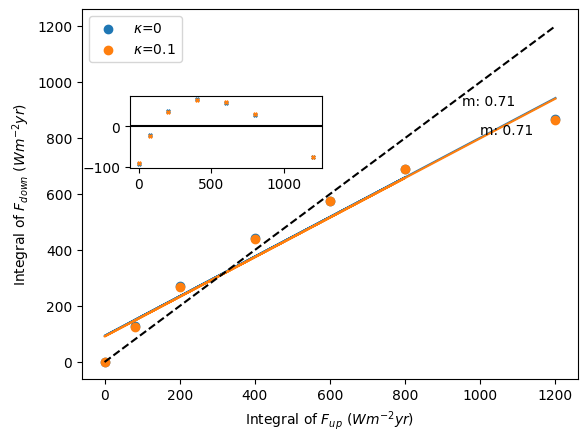

In [175]:
import matplotlib.pyplot as plt
#import math
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time
#ts = [10,25,50, 75, 100]


#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

t_0k = []
t_01k = []
return_times = {}

ts_instance = []
for scen in runs_new:
    run = runs_new[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #ts_instance.append(t)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i][0]
    if k == "0":
        print(t)
        fint_up.append(8 * t)
        t_0k.append(run.time[i][0])
        fint_down0.append(4 * (run.time[i][0]-t))
    else:
        t_01k.append(run.time[i][0])
        fint_down01.append(4 * (run.time[i][0]-t))

#print(t_0k, t_01k)
#print(return_times)
#print(ts_instance)


#fint_up = np.sort(fint_up)

#for ind, t in enumerate(ts_instance):
  #  fint_up.append( 8 * t)
  #  fint_down0.append(4 * (t_0k[ind]-t))
   # fint_down01.append(4 * (t_01k[ind]-t))


#Fitting using lstsqs

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m1, c1 = np.linalg.lstsq(A, fint_down01, rcond=None)[0]
print(m1,c1)

A = np.vstack([fint_up, np.ones(len(fint_up))]).T
m0, c0 = np.linalg.lstsq(A, fint_down0, rcond=None)[0]
print(m0,c0)

xs = np.array(fint_up)
residuals0 = (fint_down0 - ( m0 * xs + c0) )
residuals01 = (fint_down01 - ( m1 * xs + c1 ))

fig, axs = plt.subplots()

axs.scatter(fint_up, fint_down0, label = "$\kappa$=0")
axs.scatter(fint_up, fint_down01, label = "$\kappa$=0.1")
axs.plot(xs, m0 * xs + c0)
axs.plot(xs, m1 * xs + c1)
axs.plot(np.sort(xs), np.sort(xs), "k", linestyle= "dashed")
axs.set_xlabel("Integral of $F_{up}$ ($Wm^{-2} yr$)")
axs.set_ylabel("Integral of $F_{down}$ ($Wm^{-2} yr$)")
axs.annotate(f"m: %s"%"{:.2f}".format(m0) , (xs[-1]-250,fint_down0[-1]+50))
axs.annotate(f"m: %s"%"{:.2f}".format(m1) , (xs[-1]-200,fint_down01[-1]-50 ))
axs.legend()


l, b, h, w = .2, .55, .15, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.scatter(xs, residuals0, marker="x", s = 6)
ax2.scatter(xs, residuals01, marker="x", s = 6)
ax2.axhline(0, color="k")

[   0   80  200  400  600  800 1200]


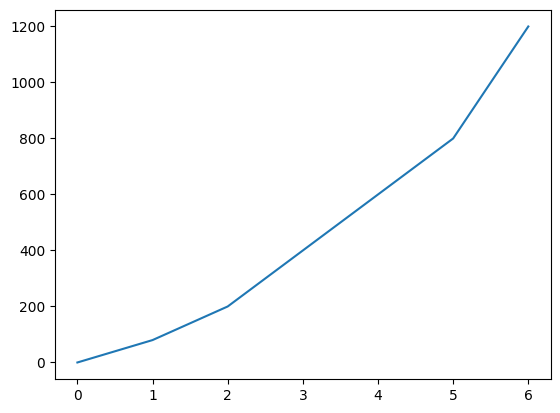

In [172]:
print(fint_up)
plt.plot(np.sort(fint_up, axis=0))

1196.0


Text(400, 1, '')

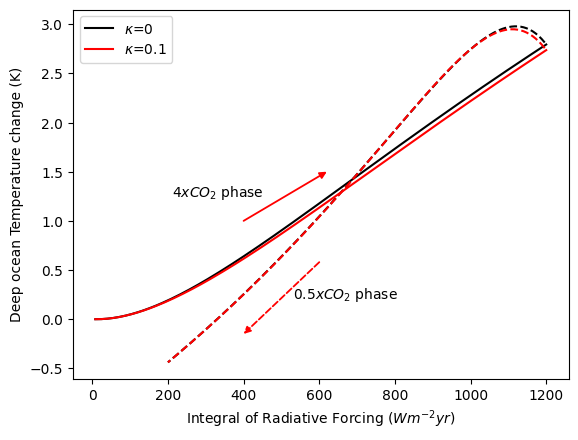

In [220]:
for name in runs_new:
    #print(name)
    i = name.index("t")
    j = name.index(",")
    t = int(name[i+4:j])
    if t != 150:
        continue 
    l = name.index("k")
    k = name[l+4:]
    #print(k)
    if k == "0":
        color = "black"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_new[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0")
        plt.plot(f_down[:250] + f_up[-1] , run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    if k == "0.1":
        color = "red"
        force = f_scenarios[t]
        f_up = np.cumsum(force[:t])
        f_down = np.cumsum(force[t:])
        run = runs_new[name]
        plt.plot(f_up, run.tlev[:,1][:t], color = color, label = "$\kappa$=0.1")
        print(f_up[-1] + f_down[0])
        plt.plot(f_down[:250] + f_up[-1], run.tlev[:,1][t:][:250], linestyle = "dashed", color = color)
    plt.xlabel("Integral of Radiative Forcing ($Wm^{-2} yr$)")
    plt.ylabel("Deep ocean Temperature change (K)")
    plt.legend()

arrowStart=np.array([400,-0.15])
arrowStop=np.array([600,0.58])
arrowColor="red"
plt.annotate("$0.5 x CO_2$ phase",(((arrowStop+arrowStart)/2)[0]+30,((arrowStop+arrowStart)/2)[1]) )
plt.annotate("",arrowStart,xytext=arrowStop,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor,linestyle="dashed", lw=1.3))

arrowStart2=np.array([620,1.5])
arrowStop2=np.array([400,1])
arrowColor2="red"
plt.annotate("$4 x CO_2$ phase",(((arrowStop2+arrowStart2)/2)[0]-300,((arrowStop2+arrowStart2)/2)[1]) )
plt.annotate("",arrowStart2,xytext=arrowStop2,arrowprops=dict(arrowstyle="-|>",shrinkA=0,shrinkB=0,edgecolor=arrowColor,facecolor=arrowColor2, lw=1.3))

We dont need to test different t's